In [2]:
# To make plot backgrounds white
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"
import sympy as sym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Functions to get matrices
def M_quad( K, gamma0 = 1.1, approx = 'thinLens', skew = False, L = 1., show = False ):
    '''
    Returns the linear map of a quadrupole
    K : (float) the quadrupole gradient [T/m]
    gamma0 : (float) gamma of reference particle [ ]
    approx : (string) can bee "thin lens", "achromatic"
    skew : (boolean) skew dipole or not
    L : (float) Length of the quad. Not necessary for thin lens approximation    
    '''
    # Get normalised K
    qmcRatio = 1758.82  # q / m*c
    P0 = np.sqrt( np.power(gamma0,2.) - 1 )
    if show:
        print('P0 = ', P0)
    K *= q / P0
    
    M = np.diag( np.ones(6) )
    if approx == 'thinLens':    
        M = np.diag( np.ones(6) ) + np.diag([ -K * L, 0, K * L, 0, 0 ], k = -1)
    elif approx == 'achromatic':
        if isinstance(K,sym.Expr):
            w = sym.sqrt(K)
            c = sym.cos(w*L)
            s = sym.sin(w*L)
            ch = sym.cosh(w*L)
            sh = sym.sinh(w*L)
        else:
            w = np.sqrt(K)
            c = np.cos(w*L)
            s = np.sin(w*L)
            ch = np.cosh(w*L)
            sh = np.sinh(w*L)            
        M = np.diag( [c,c,ch,ch, 1, 1] )
        M += np.diag( [-w*s, 0, w*sh, 0, 0], k = -1 )
        M += np.diag( [s/w, 0, sh/w, 0, L / np.power(P0, 2.)], k = 1 )        

        # Rotate matrix if skew quad
    if skew:
        R = rot(np.pi/4)
        M = np.linalg.multi_dot([R,M,R.T])
        
    return M

def M_drift( L = 1., gamma0 = 1.1 ):
    '''
    Returns the linear map of a drift
    L : (float) Length of the drift.
    gamma0 : (float) gamma of reference particle [ ]
    '''
    beta0 = np.sqrt( 1 - 1 / np.power(gamma0,2.) )
    return np.diag(np.ones(6)) + np.diag( [L, 0, L, 0, L / np.power(beta0*gamma0, 2.)], k = 1 )

def rot( alpha = 0. ):
    '''
    Returns a rotation 6x6 matrix around the z axis
    alpha : (float) angle of rotation
    '''
    M = np.diag( np.ones(6)*np.cos(alpha) )
    M[-1,-1] = 1
    M[-2,-2] = 1
    s = np.sin(alpha)
    M[2,0] = s
    M[3,1] = s
    M[0,2] = -s
    M[1,3] = -s
    return M

    Next drift Type    On  Max gradient  Length   Skew      Pos
0       0.2470   Rs     0           9.0    0.10   True  12.4602
1       0.3830   Rs     0           9.0    0.10   True  12.7072
2       0.7075   Rs     0           9.0    0.10   True  13.0902
3       0.2650  IMP  True          15.0    0.12  False  13.7977
4       0.2515  IMP  True          15.0    0.12  False  14.0627
5       0.2700  IMP  True          15.0    0.12  False  14.3142
6       2.3370  IMP  True          15.0    0.12  False  14.5842
7       0.3480    P     0           3.0    0.10  False  16.9212
8       0.3090    P     0           3.0    0.10  False  17.2692
9       6.1865    P     0           3.0    0.10  False  17.5782
10      0.2520  IMP     0          15.0    0.12  False  23.7647
11      0.2580  IMP     0          15.0    0.12  False  24.0167
12      1.9980  IMP     0          15.0    0.12  False  24.2747


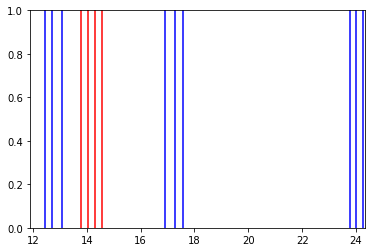

In [4]:
# Quad parameters in a dataframe
# All units in meters
L6 = 10.36
first_quad_pos = L6 + ( 121.07 + 88.95 ) * 1e-2
# Here give quad types and parameters
# Syntax: [L_drift that follows quad, type, on or off [0,1]]
quads = [[.247, 'Rs', 0], [.383, 'Rs', 0], [.7075, 'Rs', 0],
         [.265, 'IMP', True], [.2515, 'IMP', True], [.27, 'IMP', True], [2*.547 + 1.02 + .223 , 'IMP', True],
         [.348, 'P', 0], [.309, 'P', 0], [.4005 + 1.285 + .7 + .724 + .83 + .39 + 1.083 + .774, 'P', 0],
         [.252, 'IMP', 0], [.258, 'IMP', 0], [.994 + 1.004, 'IMP', 0]]
# Syntax 'name' : [ max_grad, length, skew_boolean [0,1] ]
quad_dict = {'Rs' : [9,.1,1], 'R' : [9,.1,0], 'P' : [3,.1,0], 'IMP' : [15,.12,0]}
quads = pd.DataFrame( quads, columns = ['Next drift', 'Type', 'On'])
quads['Max gradient'] = np.nan
quads['Length'] = np.nan
quads['Skew'] = np.nan
quads['Pos'] = np.nan
pos = first_quad_pos
fig,ax = plt.subplots()
for i, r in quads.iterrows():
    info = quad_dict[r['Type']]
    quads.loc[i,'Max gradient'] = info[0]
    quads.loc[i,'Length'] = info[1]
    quads.loc[i,'Skew'] = bool(info[2])
    quads.loc[i,'Pos'] = pos
    if r['On']:
        c = 'r'
    else:
        c = 'b'
    ax.axvline(pos, color = c)
    pos += r['Next drift']
print(quads)
plt.show()

In [5]:
# Set beam parameters
E = 50  # MeV
mc2 = .511
gamma0 = E / mc2
P0 = np.sqrt( np.power(gamma0,2.) - 1 )
print('Reference particle has gamma = ', gamma0, '\n and momentum P0 = ', P0 )

# Fake beam moments matrix
x2 = np.power(8e-4,2.)  # Beam size
p2 = np.power(.1/P0,2.)  # Normalised momentum spread
xpx = -.7
sig = np.array([
    [sigx2, xpx],
    [xpx, sigp2] ])
Z = np.zeros([2,2])
sig = np.block([
    [sig, Z],
    [Z, sig] ])
print(sig)

Reference particle has gamma =  97.84735812133073 
 and momentum P0 =  97.84224798789093


NameError: name 'sigx2' is not defined

In [201]:
# Make matrices
numQ = int( np.sum(quads['On']) )  # Number of quads
Ks = sym.symbols('K0:%d'%numQ)  # Quadrupole strengths
Klims = np.zeros(numQ)
print(Ks)
Ms = []
prevpos = first_quad_pos
qi = 0
for i, r in quads.iterrows():
    if r['On']:
        Ms.append( M_drift( L = r['Pos'] - prevpos, gamma0 = gamma0  ) )
        Ms.append( M_quad( K = Ks[qi] , gamma0 = gamma0, approx = 'thinLens') )
        Klims[qi] = r['Max gradient']
        prevpos = r['Pos']
        qi += 1
    if i == quads.shape[0]-1:
        Ms.append( M_drift( L = r['Pos'] + r['Next drift'] - prevpos, gamma0 = gamma0  ) )
           
Mtot = np.linalg.multi_dot(Ms)[:4,:4]
for M in Ms:
    print(M, '\n\n')
print(Mtot)
#print(np.linalg.det(Mtot))        

(K0, K1, K2, K3)
[[1.00000000e+00 1.33750000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.33750000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 1.39714328e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]] 


[[1.0 0.0 0.0 0.0 0.0 0.0]
 [0.0102205337731382*K0 1.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 1.0 0.0 0.0 0.0]
 [0.0 0.0 -0.0102205337731382*K0 1.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 1.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 1.0]] 


[[1.00000000e+00 2.65000000e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00

[[0.0136699639215723*K0*(0.00270844144988162*K1*(0.00257046424394425*K2*(0.0027595441187473*K3 + 1.0) + 0.00533000836269155*K3 + 1.0) + 0.00527890569382587*K2*(0.0027595441187473*K3 + 1.0) + 0.00803844981257318*K3 + 1.0) + 0.0163784053714539*K1*(0.00257046424394425*K2*(0.0027595441187473*K3 + 1.0) + 0.00533000836269155*K3 + 1.0) + 0.0189488696153982*K2*(0.0027595441187473*K3 + 1.0) + 0.0217084137341455*K3 + 1.0
  0.0136699639215723*K0*(0.00270844144988162*K1*(0.00257046424394425*K2*(0.0322549314319778*K3 + 11.9585) + 0.0622998027473202*K3 + 12.21) + 0.00527890569382587*K2*(0.0322549314319778*K3 + 11.9585) + 0.0939574206342616*K3 + 12.475) + 0.0163784053714539*K1*(0.00257046424394425*K2*(0.0322549314319778*K3 + 11.9585) + 0.0622998027473202*K3 + 12.21) + 0.0189488696153982*K2*(0.0322549314319778*K3 + 11.9585) + 0.253738793931559*K3 + 13.8125
  0 0]
 [0.0102205337731382*K0*(0.00270844144988162*K1*(0.00257046424394425*K2*(0.0027595441187473*K3 + 1.0) + 0.00533000836269155*K3 + 1.0) + 0.00

In [196]:
# Solve for sigFinal = sig
sigFinal = np.linalg.multi_dot( [Mtot, sig, Mtot.T] )
diff = sigFinal - sig
quants = [diff[0,0], diff[2,2]]
sols = sym.solve( quants, Ks, dict = True )
print( "Hello there general Kenobi, I have found the solution young Skywalker")
#print(sols)


KeyboardInterrupt: 

In [189]:
nsols = len(sols)
nfp = numQ - len(sols[0])
print('There are ', nsols, ' solutions, with ', nfp, ' free parameters.')
print( '\n', sols[0] )
print( '\n', sols[0][Ks[0]].subs(Ks[1],+1).subs(Ks[2], -15) )

#print(quants[0].subs(Ks[1],0))

There are  2  solutions, with  2  free parameters.

 {K0: -182.882706519422*(5.36626862440033e+77*K1**2*K2**2 + 4.21923573534664e+80*K1**2*K2 + 8.29255096997896e+82*K1**2 + 6.48428562439401e+80*K1*K2**2 + 3.47392934693725e+83*K1*K2 + 3.63450277954821e+85*K1 + 1.83140931250338e+83*K2**2 + 4.58563904498271e+85*K2 + 2.01233563472316e+87)/(2.21850418949468e+77*K1**2*K2**2 + 1.74430182506531e+80*K1**2*K2 + 3.4282777020974e+82*K1**2 + 3.36436521240928e+80*K1*K2**2 + 1.9737039335133e+83*K1*K2 + 2.55902169453541e+85*K1 + 1.27551632943365e+83*K2**2 + 4.93686228138922e+85*K2 + 4.77487377755157e+87) - 1.87248806138064e+88*sqrt(4.70243357944209e-47*K1**4*K2**4 + 7.39459155056957e-44*K1**4*K2**3 + 4.36034951276838e-41*K1**4*K2**2 + 1.14269471596625e-38*K1**4*K2 + 1.12293528326494e-36*K1**4 + 8.99903448831661e-44*K1**3*K2**4 + 1.20292208183861e-40*K1**3*K2**3 + 5.83493562604343e-38*K1**3*K2**2 + 1.1974996130714e-35*K1**3*K2 + 8.49052324876762e-34*K1**3 + 4.66700628175967e-41*K1**2*K2**4 + 5.31289728